# French Embeddings

This notebook makes embeddings for the french part of the corpus 

In [29]:
#needed imports and packages 

import pandas as pd
# %pip install gensim
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import matplotlib.pyplot as plt

[nltk_data] Downloading package punkt to /Users/emma/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [30]:
#read in the corpus data 

file = "europarl_corpus.csv"
df = pd.read_csv(file)
df = df.drop("Unnamed: 0", axis = 1)

print(df.head())

  native_language utterance_language translated  \
0         Unknown                 FR    unknown   
1         Unknown                 EN    unknown   
2         Unknown                 FR    unknown   
3         Unknown                 EN    unknown   
4         Unknown                 FR    unknown   

                                            sentence  
0  Je déclare reprise la session du Parlement eur...  
1  I declare resumed the session of the European ...  
2  Vous avez souhaité un débat à ce sujet dans le...  
3  You have requested a debate on this subject in...  
4  En attendant , je souhaiterais , comme un cert...  


In [31]:
#make two dataframes -- one for untranslated english data and one for translated english data 

u_df = df[(df['utterance_language'] == 'FR') & (df['translated'] == 'NO')] #untranslated sentences 
u_df = u_df.dropna()
print(u_df.head())
print(u_df.shape[0])

t_df = df[(df['utterance_language'] == 'FR') & (df['translated'] == 'YES')] #translated sentences
t_df = t_df.dropna()
t_df = t_df.sample(129840) #pick a random 129,840 (number of originally english sentences) rows from translated DF 
print(t_df.head())

    native_language utterance_language translated  \
118              FR                 FR         NO   
120              FR                 FR         NO   
124              FR                 FR         NO   
708              FR                 FR         NO   
710              FR                 FR         NO   

                                              sentence  
118                  Ce n' est pas demander beaucoup .  
120  Donc , je réitère la proposition de maintenir ...  
124  Madame la Présidente , je voudrais remercier M...  
708  Monsieur le Président , Monsieur le Commissair...  
710  Cependant , j' estime que l' évocation d' une ...  
129840
        native_language utterance_language translated  \
2634926              NL                 FR        YES   
1444958              RO                 FR        YES   
2110150              IT                 FR        YES   
267776               EN                 FR        YES   
609138               NL                 FR     

In [32]:
#arbitrarily create a list of terms likely to appear in a political corpus 
    #this is literally based on the fact that i did MUN for four years in HS and was the SG my senior year

terms = ["économie", "rapport", "voter", "dénoncer", "aborder", "modification", "délai", "éducation"]

In [33]:
#count occurrences of each term so i can add a ✨table✨ in the paper and take up more space 

for term in terms: 
    occurences = u_df['sentence'].str.count(term).sum()
    print(term, "appears", occurences, "times in the untranslated corpus")

for term in terms: 
    occurences = t_df['sentence'].str.count(term).sum()
    print(term, "appears", occurences, "times in the translated corpus")

économie appears 1320 times in the untranslated corpus
rapport appears 10996 times in the untranslated corpus
voter appears 1039 times in the untranslated corpus
dénoncer appears 198 times in the untranslated corpus
aborder appears 205 times in the untranslated corpus
modification appears 403 times in the untranslated corpus
délai appears 561 times in the untranslated corpus
éducation appears 632 times in the untranslated corpus
économie appears 1500 times in the translated corpus
rapport appears 11237 times in the translated corpus
voter appears 745 times in the translated corpus
dénoncer appears 69 times in the translated corpus
aborder appears 507 times in the translated corpus
modification appears 571 times in the translated corpus
délai appears 551 times in the translated corpus
éducation appears 534 times in the translated corpus


In [34]:
#produce cbow embeddings for untranslated terms 

sentences = u_df['sentence'].dropna().tolist()
tokenized_sentences = [word_tokenize(sentence.lower()) for sentence in sentences]

#reminder that sg=0 is CBOW, sg=1 is Skip-gram
model = Word2Vec(sentences=tokenized_sentences, vector_size=100, window=5, min_count=1, sg=0)

#get embeddings 
u_term_embeddings = {}
for term in terms:
    if term in model.wv:
        u_term_embeddings[term] = model.wv[term]
    else:
        print(f"'{term}' not found in vocabulary.")

print(u_term_embeddings.get('économie')) #making sure shit works 

[-0.3573812   1.6558884  -1.4083574   3.1183786  -1.3389249   0.9093229
 -0.82799363  2.608681    0.71839106 -1.1321837   0.16947253  1.963747
  0.9283275  -1.8600156  -2.0226283   0.2581827   1.4098296  -0.05270467
  0.9152057  -0.20574032  0.47587308  3.5406375   0.6624517  -1.3139161
  0.09989693  0.42476118 -2.8937733  -4.030983   -0.29048193 -0.7683613
 -2.5249498   0.8182207  -0.39812872 -1.4232239   2.025959    2.0168698
  0.14455023 -0.7896579  -0.94471455 -0.84360844  0.6114845   0.84911805
 -1.7212232  -0.14582977  0.5424483   2.1256912   0.5498067  -1.1445507
  1.6269518  -0.23209512  1.5014181  -0.5795604   0.54375714  0.13591562
  1.0643947  -1.394626    0.3855965  -0.84953856  2.3079531   0.4769036
 -1.0549629   1.5306568  -0.36074856  0.13638255 -0.49725947 -1.2848645
 -1.6068392  -1.0781882  -0.42547864  0.85469455  2.2223556   0.9496726
  0.49045658 -1.0624039  -1.2591898   0.53385955  0.5133503  -0.57213205
  0.7356795   1.4493033  -0.19415024  0.3602483   0.19752596 

In [35]:
#produce cbow embeddings for translated terms 

sentences = t_df['sentence'].dropna().tolist()
tokenized_sentences = [word_tokenize(sentence.lower()) for sentence in sentences]

#reminder that sg=0 is CBOW, sg=1 is Skip-gram
model = Word2Vec(sentences=tokenized_sentences, vector_size=100, window=5, min_count=1, sg=0)

#get embeddings 
t_term_embeddings = {}
for term in terms:
    if term in model.wv:
        t_term_embeddings[term] = model.wv[term]
    else:
        print(f"'{term}' not found in vocabulary.")

print(t_term_embeddings.get('économie')) #making sure shit works 

[ 0.02702042 -0.72697     0.774359   -0.05997868  1.3701519  -1.0062765
  0.27451274 -1.4518629   2.7871778  -0.09873652  0.33883214  0.9637057
 -0.14573085  0.8218118  -2.8409014   1.2828217  -2.7649202   0.2768098
 -0.07690682 -0.74257123  0.98190147  1.9049248  -0.24035463 -0.9951014
 -1.9271002  -1.8130258   2.9377     -0.6002549   0.66421217  0.2626215
  1.0085659   0.74995553 -0.08264663 -1.2776048   0.927352    0.22673799
 -1.4433917  -1.6600028  -1.0817194   0.24585731 -0.15953556 -3.0952458
 -1.5971025  -0.78813165  1.3198707  -0.02991331 -1.8089927   1.601799
 -1.0085746   0.98104054  1.9783022  -0.7210856  -0.41901964 -0.00700106
  1.4907926   1.1207497   0.85126644 -1.6888632   2.2711856  -1.5638512
 -1.4631754  -0.87185246  1.2573324  -1.1600813   0.8168125  -0.496955
 -0.00974028 -0.5701321   0.01526215 -0.4938578   0.52194077 -3.7852423
  2.136171    2.1675673  -0.8776915   0.06170106  1.5070751  -1.8614929
 -1.0950154  -2.733396   -0.8287122  -1.0533828   0.17238435  1.

In [36]:
#calculate cosine similarity between embeddings 
overlap_scores = {}
for term in terms:
    u_vec = u_term_embeddings.get(term)
    t_vec = t_term_embeddings.get(term)
    
    if u_vec is not None and t_vec is not None:
        sim = cosine_similarity([u_vec], [t_vec])[0][0]
        overlap_scores[term] = sim
    else:
        overlap_scores[term] = None

In [42]:
#get some info
for term, score in overlap_scores.items():
    print(f"{term}: {score}")

#find max and min overlaps 
valid_scores = {term: score for term, score in overlap_scores.items()}

max_term = max(valid_scores, key=valid_scores.get)
max_score = valid_scores[max_term]

min_term = min(valid_scores, key=valid_scores.get)
min_score = valid_scores[min_term]

print(f"Max similarity: {max_term} -> {max_score}")
print(f"Min similarity: {min_term} -> {min_score}")

économie: 0.0018764100968837738
rapport: 0.22463035583496094
voter: -0.054208964109420776
dénoncer: 0.0793825089931488
aborder: 0.137935608625412
modification: -0.11477424949407578
délai: 0.1288279891014099
éducation: -0.10323797166347504
Max similarity: rapport -> 0.22463035583496094
Min similarity: modification -> -0.11477424949407578


In [37]:
#i call this move avoiding errors 

filtered_terms = [term for term, score in overlap_scores.items() if score is not None]
filtered_scores = [overlap_scores[term] for term in filtered_terms]

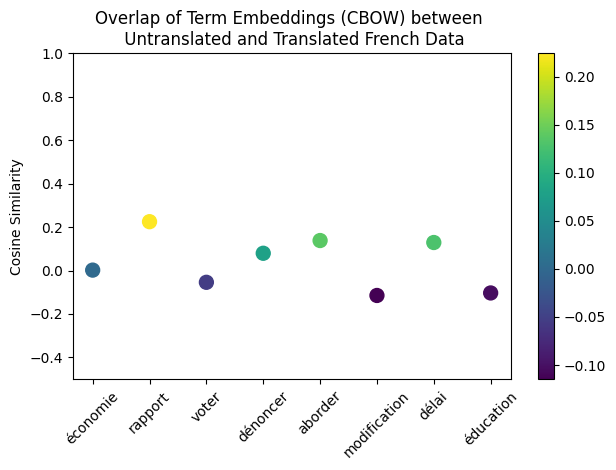

In [48]:
scores_array = np.array(filtered_scores)
scatter = plt.scatter(filtered_terms, filtered_scores, c=scores_array, cmap='viridis', s=100)

plt.ylim(-0.5, 1)
plt.ylabel("Cosine Similarity")
plt.title("Overlap of Term Embeddings (CBOW) between \n Untranslated and Translated French Data")
plt.xticks(rotation=45)
plt.colorbar(scatter)  
plt.tight_layout()

#save the graph as a file so I can use it in the paper 
plt.savefig('french_cos.png')

plt.show()

In [50]:
#for rapport: comparing translated - translated, untranslated - untranslated, translated - untranslated 

#untranslated - untranslated
u_df_1 = u_df.sample(217421 // 2) #randomly get half of the u_df corpus 
u_df_2 = u_df.sample(217421 // 2) #randomly get half of the u_df corpus  

sentences_1 = u_df_1['sentence'].dropna().tolist()
sentences_2 = u_df_2['sentence'].dropna().tolist()

tokenized_sentences_1 = [word_tokenize(sentence.lower()) for sentence in sentences_1]
tokenized_sentences_2 = [word_tokenize(sentence.lower()) for sentence in sentences_2]

model_1 = Word2Vec(sentences=tokenized_sentences_1, vector_size=100, window=5, min_count=1, sg=0)
model_2 = Word2Vec(sentences=tokenized_sentences_2, vector_size=100, window=5, min_count=1, sg=0)

if "rapport" in model_1.wv and "rapport" in model_2.wv:
    vec_1 = model_1.wv["rapport"]
    vec_2 = model_2.wv["rapport"]

    # Reshape vectors to be 2D (required by cosine_similarity)
    vec_1 = vec_1.reshape(1, -1)
    vec_2 = vec_2.reshape(1, -1)

    similarity = cosine_similarity(vec_1, vec_2)[0][0]
    print(f"Cosine similarity between 'rapport' in both models: {similarity:.4f}")
else:
    print("out of vocabulary :(")

#translated - translated
t_df_1 = t_df.sample(217421 // 2) #randomly get half of the u_df corpus 
t_df_2 = t_df.sample(217421 // 2) #randomly get half of the u_df corpus  

sentences_1 = u_df_1['sentence'].dropna().tolist()
sentences_2 = u_df_2['sentence'].dropna().tolist()

tokenized_sentences_1 = [word_tokenize(sentence.lower()) for sentence in sentences_1]
tokenized_sentences_2 = [word_tokenize(sentence.lower()) for sentence in sentences_2]

model_1 = Word2Vec(sentences=tokenized_sentences_1, vector_size=100, window=5, min_count=1, sg=0)
model_2 = Word2Vec(sentences=tokenized_sentences_2, vector_size=100, window=5, min_count=1, sg=0)

if "rapport" in model_1.wv and "rapport" in model_2.wv:
    vec_1 = model_1.wv["rapport"]
    vec_2 = model_2.wv["rapport"]

    # Reshape vectors to be 2D (required by cosine_similarity)
    vec_1 = vec_1.reshape(1, -1)
    vec_2 = vec_2.reshape(1, -1)

    similarity = cosine_similarity(vec_1, vec_2)[0][0]
    print(f"Cosine similarity between 'rapport' in both models: {similarity:.4f}")
else:
    print("out of vocabulary :(")

Cosine similarity between 'rapport' in both models: 0.5231
Cosine similarity between 'rapport' in both models: 0.6063


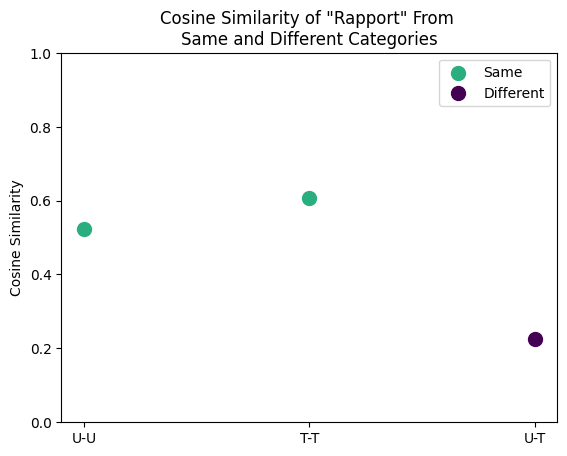

In [54]:
#plot similarities 

x = ["U-U", "T-T", "U-T"]
y = [0.5231, 0.6063, 0.22463035583496] 


plt.ylim(0, 1)
plt.ylabel("Cosine Similarity")
plt.title("Cosine Similarity of \"Rapport\" From \nSame and Different Categories")

plt.scatter(x[:2], y[:2], color='#29af7f', label='Same', marker='o', s = 100)
plt.scatter(x[2:], y[2:], color='#440154', label='Different', marker='o', s = 100)

plt.legend()

plt.savefig('rapport.png')